# Set up

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!cp /content/drive/MyDrive/MMDS/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()

# Test

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, array

In [5]:
spark = SparkSession.builder.appName("Experiment").getOrCreate()

df = spark.range(1000).withColumn("embedding", array([rand() for _ in range(32)]))

In [6]:
df.show(5, truncate=False)

+---+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |embedding                                                                                                                                                                                                                                                                                                                                          

# Sampling

In [7]:
# Sampling
sampled_df = df.sample(False, 0.25, seed=42)

In [8]:
sampled_df.show(5, truncate=False)

+---+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |embedding                                                                                                                                                                                                                                                                                                                                    

# Hierarchical Clustering

In [189]:
sampled_in_memory = sampled_df.select("embedding").collect()

In [190]:
sampled_in_memory[0]

Row(embedding=[0.08157693752337081, 0.25167139486122525, 0.40268467850337863, 0.4847513728159256, 0.9844858826517959, 0.08645220549992605, 0.4981668149681212, 0.458273875805177, 0.543335109279136, 0.21086800450578003, 0.05257363724908404, 0.33526523609341885, 0.20671343380589546, 0.24272654329759047, 0.5309729876101766, 0.9787757392990415, 0.5081603639416843, 0.3429812934406282, 0.5655954805953726, 0.2798557774249606, 0.07446741399318468, 0.5148243741486992, 0.2221734104928521, 0.42016723982340687, 0.31796680272121314, 0.3151443750505051, 0.401453679270093, 0.7228476793677855, 0.35543447035587294, 0.590356030480974, 0.7781121627566324, 0.250859452072683])

In [191]:
np_sampled = np.array([np.array(row["embedding"])
                        for row in sampled_in_memory])

In [192]:
np_sampled.shape

(247, 32)

In [165]:
from sklearn.cluster import AgglomerativeClustering

In [193]:
k_trial = 10
clustering = AgglomerativeClustering(n_clusters=k_trial, linkage="ward")
model = clustering.fit(np_sampled)

In [198]:
predicted = model.labels_

In [200]:
from collections import defaultdict

In [201]:
n = len(predicted)
cluster_id_A_points = defaultdict(list)
for i in range(n):
    cluster_id_A_points[predicted[i]].append(np_sampled[i])

In [204]:
list(cluster_id_A_points.items())[0]

(2,
 [array([0.08157694, 0.25167139, 0.40268468, 0.48475137, 0.98448588,
         0.08645221, 0.49816681, 0.45827388, 0.54333511, 0.210868  ,
         0.05257364, 0.33526524, 0.20671343, 0.24272654, 0.53097299,
         0.97877574, 0.50816036, 0.34298129, 0.56559548, 0.27985578,
         0.07446741, 0.51482437, 0.22217341, 0.42016724, 0.3179668 ,
         0.31514438, 0.40145368, 0.72284768, 0.35543447, 0.59035603,
         0.77811216, 0.25085945]),
  array([0.26131631, 0.79216719, 0.23946093, 0.47095186, 0.79994401,
         0.11350639, 0.77940405, 0.67099249, 0.28006102, 0.17181873,
         0.64088938, 0.78729555, 0.74799228, 0.55142525, 0.82804858,
         0.79504512, 0.57361495, 0.7574611 , 0.78592883, 0.66368599,
         0.77911539, 0.40920175, 0.43084991, 0.13641408, 0.10078046,
         0.61494452, 0.70585816, 0.74486748, 0.27002203, 0.64315063,
         0.27648096, 0.95137395]),
  array([0.86811481, 0.10852158, 0.53064312, 0.986902  , 0.72050781,
         0.33304552, 0.050985

In [15]:
import pyspark.sql.functions as F

In [145]:
process_cluster_df = spark.createDataFrame([
    (idx, _.tolist()) for idx, _ in enumerate(centers)],
    ["cluster_id", "centroid"])

In [146]:
process_cluster_df.show()

+----------+--------------------+
|cluster_id|            centroid|
+----------+--------------------+
|         0|[0.37586888459333...|
|         1|[0.31919863853862...|
|         2|[0.73729959744832...|
|         3|[0.62533766208403...|
|         4|[0.46946918513469...|
|         5|[0.72287230089987...|
|         6|[0.33277816516275...|
|         7|[0.32592939544204...|
|         8|[0.64147400823893...|
|         9|[0.47366806725299...|
+----------+--------------------+



In [147]:
process_cluster_df = predicted.groupBy("prediction") \
        .agg(F.collect_list("embedding").alias("embeddings")) \
        .select(F.col("prediction").alias("cluster_id"), F.col("embeddings").alias("points")) \
        .join(process_cluster_df, "cluster_id") \
        .select("cluster_id", "centroid", "points")

In [148]:
process_cluster_df.show()

+----------+--------------------+--------------------+
|cluster_id|            centroid|              points|
+----------+--------------------+--------------------+
|         0|[0.37586888459333...|[[0.1344792307647...|
|         1|[0.31919863853862...|[[0.0815769375233...|
|         2|[0.73729959744832...|[[0.6694341465455...|
|         3|[0.62533766208403...|[[0.9908077269730...|
|         4|[0.46946918513469...|[[0.5744287057224...|
|         5|[0.72287230089987...|[[0.7024476958726...|
|         6|[0.33277816516275...|[[0.0788718772844...|
|         7|[0.32592939544204...|[[0.0433303714003...|
|         8|[0.64147400823893...|[[0.6010213317958...|
|         9|[0.47366806725299...|[[0.1478524364340...|
+----------+--------------------+--------------------+



# Choose representatives

In [81]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

In [22]:
import numpy as np

In [149]:
num_reps = 4

def choose_reps(cluster_point, points, num_reps):
    if len(points) <= num_reps:
        return points

    reps = [cluster_point]
    for _ in range(num_reps):
        point_A_minimum_distances = []
        for point in points:
            if point in reps:
                continue


            point_A_minimum_distances.append(
                (
                    point,
                    min([np.linalg.norm(
                    np.array(rep) - np.array(point)) for rep in reps])
                )
            )
        rep, distance = max(point_A_minimum_distances, key=lambda x: x[1])
        reps.append(rep)
    return reps[1:]

In [150]:
choose_reps_udf = udf(lambda x, y: choose_reps(x, y, num_reps),
                    ArrayType(ArrayType(DoubleType())))

In [151]:
process_cluster_df = process_cluster_df.withColumn("reps",
                choose_reps_udf(F.col("centroid"), F.col("points")))

In [152]:
process_cluster_df.show(5)

+----------+--------------------+--------------------+--------------------+
|cluster_id|            centroid|              points|                reps|
+----------+--------------------+--------------------+--------------------+
|         0|[0.37586888459333...|[[0.1344792307647...|[[0.0625766089269...|
|         1|[0.31919863853862...|[[0.0815769375233...|[[0.6642786123352...|
|         2|[0.73729959744832...|[[0.6694341465455...|[[0.7926761781816...|
|         3|[0.62533766208403...|[[0.9908077269730...|[[0.0542145835021...|
|         4|[0.46946918513469...|[[0.5744287057224...|[[0.7252225620597...|
+----------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [153]:
_ = process_cluster_df.filter(F.col("cluster_id") == 0).collect()

In [154]:
print(len(_[0].points), len(_[0].reps))

22 4


# Visualizing

## Plot cluster, its points, its reps

In [26]:
import numpy as np
from sklearn.decomposition import PCA

In [128]:
cluster0_id, cluster0_point, points0, reps0 = process_cluster_df.filter(F.col("cluster_id") == 0).toPandas().to_numpy()[0]

In [129]:
points0_no_reps0 = [point for point in points0 if point not in reps0]

In [130]:
input = np.array(points0)
pca = PCA(n_components=2)
pca.fit(input)

PCA(n_components=2)

In [132]:
pca_points0_no_reps0 = pca.transform(np.array(points0_no_reps0))
pca_reps0 = pca.transform(np.array(reps0))

Cluster, các point trong cluster (màu lam) và các representataive (màu đỏ) map từ 32D space -> 2D space

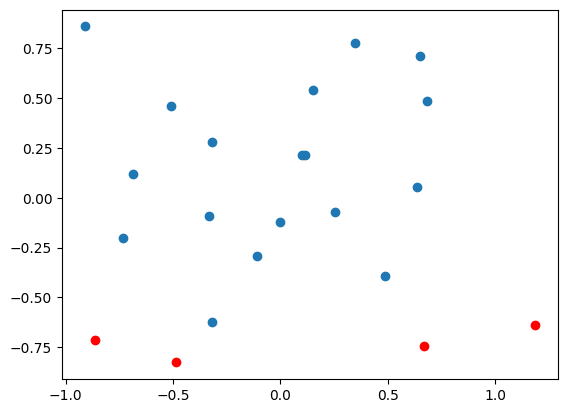

In [133]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(pca_points0_no_reps0[:, 0], pca_points0_no_reps0[:,1])
plt.scatter(pca_reps0[:,0], pca_reps0[:,1], color="red")
plt.show()

In [80]:
def no_reps(points, reps):
    return [point for point in points if point not in reps]

In [82]:
no_reps_udf = udf(lambda x, y: no_reps(x, y), ArrayType(ArrayType(DoubleType())))

In [83]:
cluster_reps_points_noreps_df = cluster_reps_points_df.withColumn("no_reps", no_reps_udf(F.col("points"), F.col("reps")))

## Plot sampled dataset

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [87]:
_ = sampled_df.select("embedding").collect()
whole_set = np.array([el.embedding for el in _])
whole_set.shape

In [90]:
pca = PCA(n_components=2)
pca.fit(whole_set)

PCA(n_components=2)

Lưu ý rằng đây là point từ 32 chiều -> 2 chiều qua PCA, chứ K-means cluster tụi nó ở 32 chiều. Nên ảnh dưới các cluster có thể chồng chéo lên nhau

['tab:blue', 'tab:orange', 'tab:red']


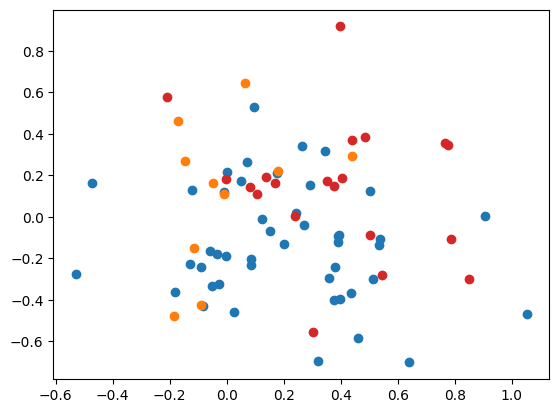

In [91]:
# Generate a color palette with 20 distinct colors
palette = sns.color_palette("husl", 20)

# Convert the palette to a list of color names
# color_names = [mcolors.to_hex(color) for color in palette]
color_names = ["tab:blue", "tab:orange", "tab:red"]
print(color_names)

step = 0
for cluster_id, cluster_point, reps, points, no_reps in tmp[:3]:
    no_reps = pca.transform(np.array(no_reps))
    reps = pca.transform(np.array(reps))
    cluster_point = pca.transform(np.array([cluster_point]))

    plt.scatter(no_reps[:, 0], no_reps[:,1], color=color_names[step])
    # plt.scatter(cluster_point[:, 0], cluster_point[:, 1], color=color_names[cluster_id + step])
    plt.scatter(reps[:,0], reps[:,1], color=color_names[step])
    step += 1
plt.show()

# Shriking representatives

In [155]:
def shrink_reps(representatives, centroid, shrink_factor):

    shrunken_reps = [
        [
            rep_coords + shrink_factor * (rep_coords - centroid_coords)
            for rep_coords, centroid_coords in zip(rep, centroid)
        ]
        for rep in representatives
    ]

    return shrunken_reps

shrink_reps_udf =  udf(lambda x, y: shrink_reps(x, y, 0.2), ArrayType(ArrayType(DoubleType())))

In [157]:
process_cluster_df = process_cluster_df.withColumn("shrunken_reps",
                            shrink_reps_udf(F.col("reps"), F.col("centroid")))

In [158]:
process_cluster_df.show()

+----------+--------------------+--------------------+--------------------+--------------------+
|cluster_id|            centroid|              points|                reps|       shrunken_reps|
+----------+--------------------+--------------------+--------------------+--------------------+
|         0|[0.37586888459333...|[[0.1344792307647...|[[0.0625766089269...|[[-8.184620630301...|
|         1|[0.31919863853862...|[[0.0815769375233...|[[0.6642786123352...|[[0.7332946070946...|
|         2|[0.73729959744832...|[[0.6694341465455...|[[0.7926761781816...|[[0.8037514943283...|
|         3|[0.62533766208403...|[[0.9908077269730...|[[0.0542145835021...|[[-0.060010032214...|
|         4|[0.46946918513469...|[[0.5744287057224...|[[0.7252225620597...|[[0.7763732374447...|
|         5|[0.72287230089987...|[[0.7024476958726...|[[0.4836032099990...|[[0.4357493918189...|
|         6|[0.33277816516275...|[[0.0788718772844...|[[0.5846401670683...|[[0.6350125674495...|
|         7|[0.32592939544204.

In [159]:
test = process_cluster_df.filter(F.col("cluster_id") == 0).select("reps", "shrunken_reps").collect()

In [160]:
len(test[0]["reps"]), len(test[0]["shrunken_reps"])

(4, 4)

Giữa reps và shruken reps không bằng nhau, chứng tỏ hàm shrinking hoạt động như mong muốn

In [161]:
test[0].reps[1] == test[0].shrunken_reps[1]

False

# Merging clusters by their reps

In [ ]:
merge_threshold = 10

